# Evaluate Proxima effect on trajectories
Here we look at the experiments where we only train a model once in NPT and look for the oscillations and the effect of blending. 

In [1]:
import os
from glob import glob
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches

from cascade.learning.torchani import TorchANI
from pathlib import Path
from ase.io import read
from ase import units
import pickle as pkl
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Read in data


In [2]:
run_dirs = sorted(glob('runs/800K-npt-single-train/si*temp=*00*blend*'))
run_dirs

['runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-00e6f7df',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-05bd7fef',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-0aff6fba',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-105292bb',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1418cfda',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-160f5dc6',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1ffe8b75',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-24aacf2b',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-2fc33503',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-399f3417',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-3c135b25',
 'runs/800K-npt-single-train/si-vacancy-2x2

In [3]:
len(run_dirs)

114

## Look at the run parameters

In [4]:
params = []
for d in run_dirs:
    try:
        params.append(json.loads((Path(d)/'params.json').read_text()))
    except: 
        print(f'couldnt find {d}/params.json; skipping')
        continue
    params[-1]['dir'] = d
params = pd.DataFrame(params)

In [5]:
params = params.query('stress_tau == 25 and steps == 2048 and temperature == 800')

In [6]:
params.columns

Index(['file', 'starting_strc', 'temperature', 'timestep', 'calculator', 'ensemble', 'temp_tau', 'stress_tau', 'steps', 'seed', 'bulk_modulus', 'model_type', 'initial_model', 'initial_data', 'ensemble_size', 'online_training', 'training_epochs', 'training_batch_size', 'training_max_size', 'training_recency_bias', 'training_device', 'target_error', 'error_history', 'retrain_freq', 'min_target_frac', 'n_blending_steps', 'cascade_commit', 'my_commit', 'start_time', 'dir'], dtype='object')

In [7]:
param_vars = ['seed', 'temperature', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps']

In [8]:
_params = params[param_vars].sort_values(param_vars)
_params.describe()

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps
count,114.000000,114.0,114.000000,114.000000,1.140000e+02,114.0,114.0
mean,2.500000,800.0,9.473684,0.305263,6.394737e-01,25.0,2048.0
std,1.715365,0.0,8.291386,0.233800,2.670284e-01,0.0,0.0
min,0.000000,800.0,0.000000,0.100000,1.000000e-12,25.0,2048.0
25%,1.000000,800.0,0.000000,0.100000,4.500000e-01,25.0,2048.0
50%,2.500000,800.0,10.000000,0.200000,4.500000e-01,25.0,2048.0
75%,4.000000,800.0,20.000000,0.500000,9.000000e-01,25.0,2048.0
max,5.000000,800.0,20.000000,1.000000,9.000000e-01,25.0,2048.0


In [9]:
assert not _params.duplicated().any()

## Read all of the trajectory data into one dataframe

In [10]:
data = []
hashes = []
for i, row in params.iterrows(): 
    # read in the results for each set of parameters
    run = row['dir']
    try:
        _data = pd.read_json(Path(run)/'proxima-log.json', lines=True)
    except: 
        print('couldnt read proximal log for', run)
        hashes.append(None)
        continue
    # make sure to have timestep
    _data.reset_index(names='timestep', inplace=True)

    # keep the hash of the run
    _hash = run.split('-')[-1]
    hashes.append(_hash)
    _data['hash'] = _hash 
    #traj = read(Path(run)/'md.traj', index=':')
    #break    
    # add the parameters to the experiment df for easy plotting, grouping, etc
    for var in param_vars:
        _data[var] = row[var]
    data.append(_data)

# track the hashes as well for param lookup
params['hash'] = hashes
data = pd.concat(data)

In [11]:
data.columns

Index(['timestep', 'step_time', 'energy', 'maximum_force', 'stress', 'temperature', 'volume', 'used_surrogate', 'proxima_alpha', 'proxima_threshold', 'proxima_blending_step', 'proxima_lambda_target', 'last_uncer', 'last_error', 'total_invocations', 'target_invocations', 'model_version', 'hash', 'seed', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps'], dtype='object')

In [12]:
data.head()

,timestep,step_time,energy,maximum_force,stress,temperature,volume,used_surrogate,proxima_alpha,proxima_threshold,proxima_blending_step,proxima_lambda_target,last_uncer,last_error,total_invocations,target_invocations,model_version,hash,seed,n_blending_steps,min_target_frac,target_error,stress_tau,steps
0,0,8.389623,-6683.994223,0.608340,"[-0.034092779847002, -0.034073754809872, -0.03...",800.0,1280.824056,False,NaN,NaN,0,NaN,0.005884,0.608359,2,2,0,00e6f7df,0,0,0.5,0.45,25.0,2048
1,1,4.706974,-6683.903042,0.920399,"[-0.033820059820491, -0.033791174174607, -0.03...",800.0,1281.576511,False,NaN,NaN,0,NaN,0.006505,0.923452,3,3,0,00e6f7df,0,0,0.5,0.45,25.0,2048
2,2,4.610480,-6683.741905,1.251025,"[-0.03360702796973, -0.033578261577978004, -0....",800.0,1282.331467,False,NaN,NaN,0,NaN,0.007204,1.257037,4,4,0,00e6f7df,0,0,0.5,0.45,25.0,2048
3,3,4.968141,-6683.542439,1.581862,"[-0.033044544383762, -0.033029409575338, -0.03...",800.0,1283.825979,False,NaN,NaN,0,NaN,0.008230,1.590637,5,5,0,00e6f7df,0,0,0.5,0.45,25.0,2048
4,4,5.258212,-6683.288967,1.905819,"[-0.03252147583357, -0.032534079113351, -0.032...",800.0,1285.327807,False,NaN,NaN,0,NaN,0.009382,1.917186,6,6,0,00e6f7df,0,0,0.5,0.45,25.0,2048


In [13]:
data.describe()

,timestep,step_time,energy,maximum_force,temperature,volume,proxima_alpha,proxima_threshold,proxima_blending_step,proxima_lambda_target,last_uncer,last_error,total_invocations,target_invocations,model_version,seed,n_blending_steps,min_target_frac,target_error,stress_tau,steps
count,233472.000000,233472.000000,233472.000000,233472.000000,233472.0,233472.000000,232788.000000,232788.000000,233472.000000,147456.000000,233472.000000,233472.000000,233472.000000,233472.000000,233472.000000,233472.000000,233472.000000,233472.000000,2.334720e+05,233472.0,233472.0
mean,1023.500000,5.351451,-6678.746915,3.390019,800.0,1359.613502,67.672071,0.789157,1.652665,0.824588,0.045531,2.162232,1113.292309,1005.782389,0.523043,2.500000,9.473684,0.305263,6.394737e-01,25.0,2048.0
std,591.207871,58.266550,3.179842,0.799011,0.0,34.466549,60.712552,4.334711,4.743134,0.366482,0.027026,1.464494,715.931860,586.376449,0.542753,1.707829,8.254958,0.232773,2.658552e-01,0.0,0.0
min,0.000000,0.022997,-6698.117097,0.574716,800.0,1223.215438,1.176802,0.000000,0.000000,0.000000,0.002380,0.263783,2.000000,2.000000,0.000000,0.000000,0.000000,0.100000,1.000000e-12,25.0,2048.0
25%,511.750000,3.133579,-6680.848143,2.852276,800.0,1336.768109,17.324897,0.000000,0.000000,1.000000,0.028212,0.835283,513.750000,513.750000,0.000000,1.000000,0.000000,0.100000,4.500000e-01,25.0,2048.0
50%,1023.500000,3.562510,-6679.029734,3.301209,800.0,1359.402380,49.541277,0.000000,0.000000,1.000000,0.038616,2.046254,1025.500000,1025.500000,1.000000,2.500000,10.000000,0.200000,4.500000e-01,25.0,2048.0
75%,1535.250000,4.557996,-6676.916770,3.812265,800.0,1381.926036,105.157022,0.000000,0.000000,1.000000,0.054703,3.295901,1658.000000,1436.000000,1.000000,4.000000,20.000000,0.500000,9.000000e-01,25.0,2048.0
max,2047.000000,3690.008584,-6663.458305,8.717689,800.0,1521.516359,557.434191,95.219279,20.000000,1.000000,0.376739,8.747930,3060.000000,2958.000000,2.000000,5.000000,20.000000,1.000000,9.000000e-01,25.0,2048.0


## compute densities

In [14]:
ang_3_to_cm_3 = 1e-24
Si_mm = 28.0855 # g / mol
N_av = 6.02e23 # n / mol
data['rho'] = 63 / data['volume']  # n / ang_3

## Plot DFT only trajectories

In [15]:
dft_only = data.query('min_target_frac == 1')

First I verify that the DFT only trajectories are what I think they are: 

In [16]:
only_target = (dft_only['total_invocations']==dft_only['target_invocations']).all()
assert only_target, 'target was not always invoked'
only_target

True

In [17]:
dft_only.hash.nunique()

6

In [18]:
no_blend = (dft_only['proxima_blending_step'] == 0).all()
assert no_blend, 'proxima should not blend'
no_blend

True

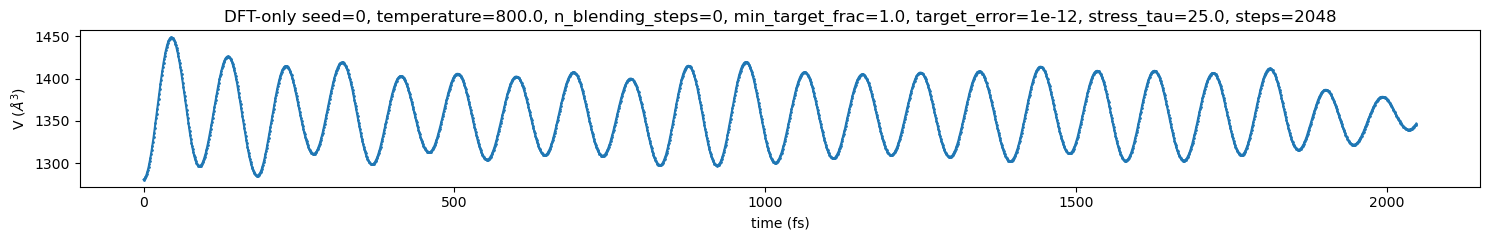

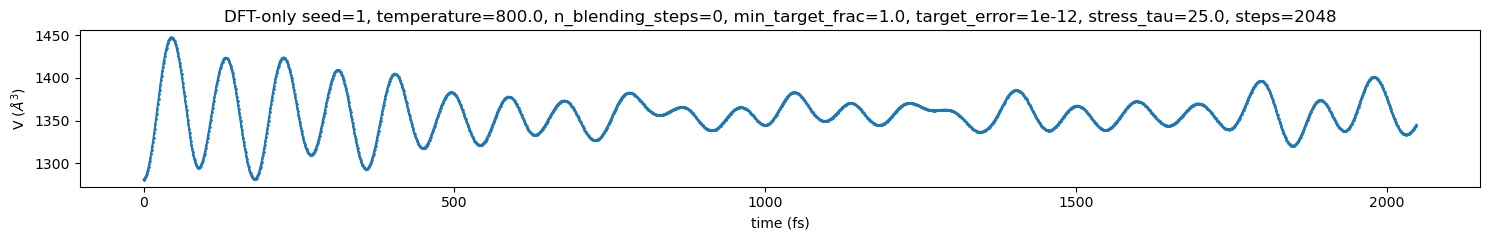

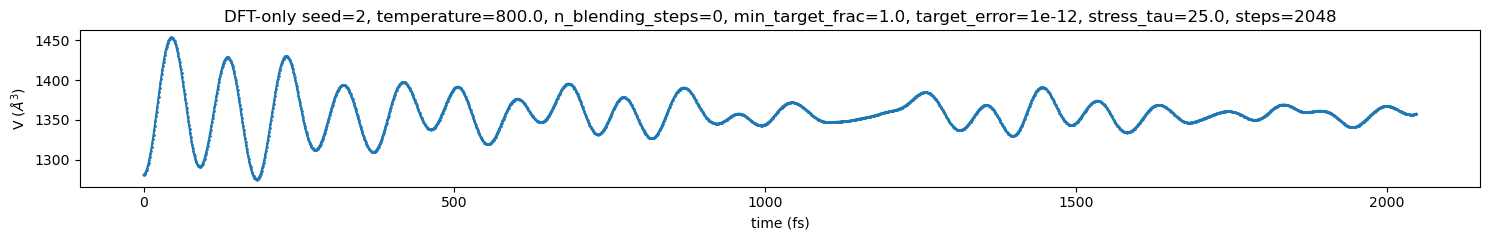

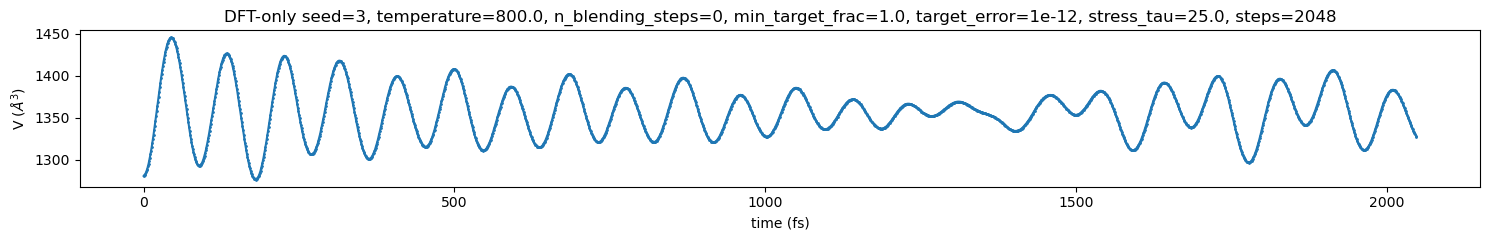

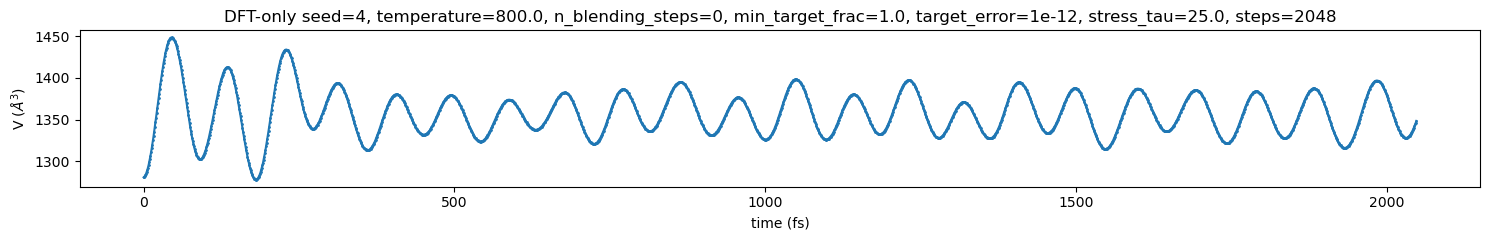

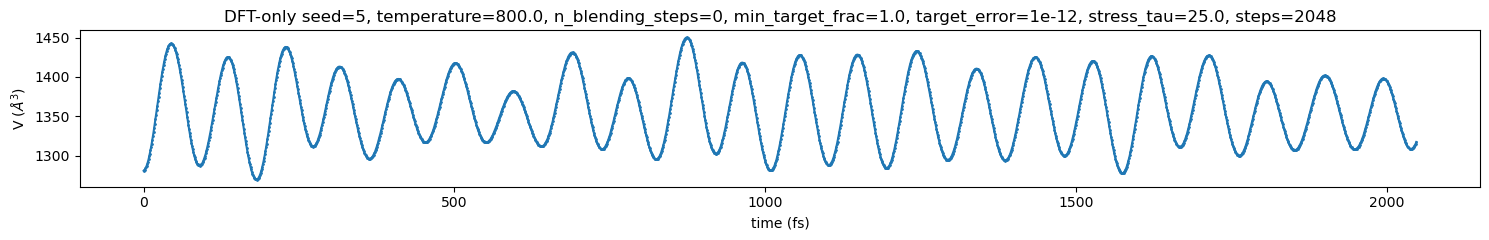

In [19]:
for i, (g, row) in enumerate(dft_only.sort_values(['hash'] + param_vars).groupby(param_vars)): 
    fig, ax = plt.subplots(figsize=(15,2.5))
    plt.plot(row['timestep'], row['volume'], '-o', ms=1)
    plt.ylabel('V ($\AA ^3$)')
    plt.xlabel('time (fs)')

    _params = params.query(f'hash == "{row["hash"].iloc[0]}"')
    _params = ', '.join([f'{var}={_params[var].iloc[0]}' for var in param_vars])
    plt.title(f"DFT-only " + _params)
    plt.tight_layout()
    plt.show()

In [20]:
rc = {'axes.titlesize':12, 
      'axes.labelsize':14, 
      'xtick.labelsize': 12, 
      'ytick.labelsize': 12, 
      'legend.fontsize': 12}

## Summary quantities
Here we'll average some quantities over our experimental conditions to get a sense of whats happening in aggregate

### Combining the dft data in for seaborn
This is a little sneaky, but it will get the DFT data on the seaborn plots without me having to plot things manualy

In [21]:
dft_only['target_error'] = 0.45

/tmp/ipykernel_340275/3036850189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_only['target_error'] = 0.45


In [22]:
# _dft_only = dft_only.copy()
# _dft_only['target_error'] = 0.9
#dft_only = pd.concat([dft_only, _dft_only])

In [23]:
dft_only.query('timestep > 1024')['volume'].mean()

1357.7273397472022

In [24]:
experimental = data.query('min_target_frac < 1').query('timestep > 1024')

In [25]:
#experimental = pd.concat([experimental, dft_only])

## Volume

Takeaways: 
* the volume matches DFT for the smaller target error (0.45)
* For the larger target error, blending only really matters for larger target fractions
   - 0.5 target fraction matches dft well, probably because mostly using DFT
 
* Notably even the largest errors are quite small percentage wise

In [26]:
rho_ref = dft_only['rho'].mean()


In [27]:
v_mean = experimental.query('timestep > 1024').groupby(param_vars)['volume'].mean().reset_index()

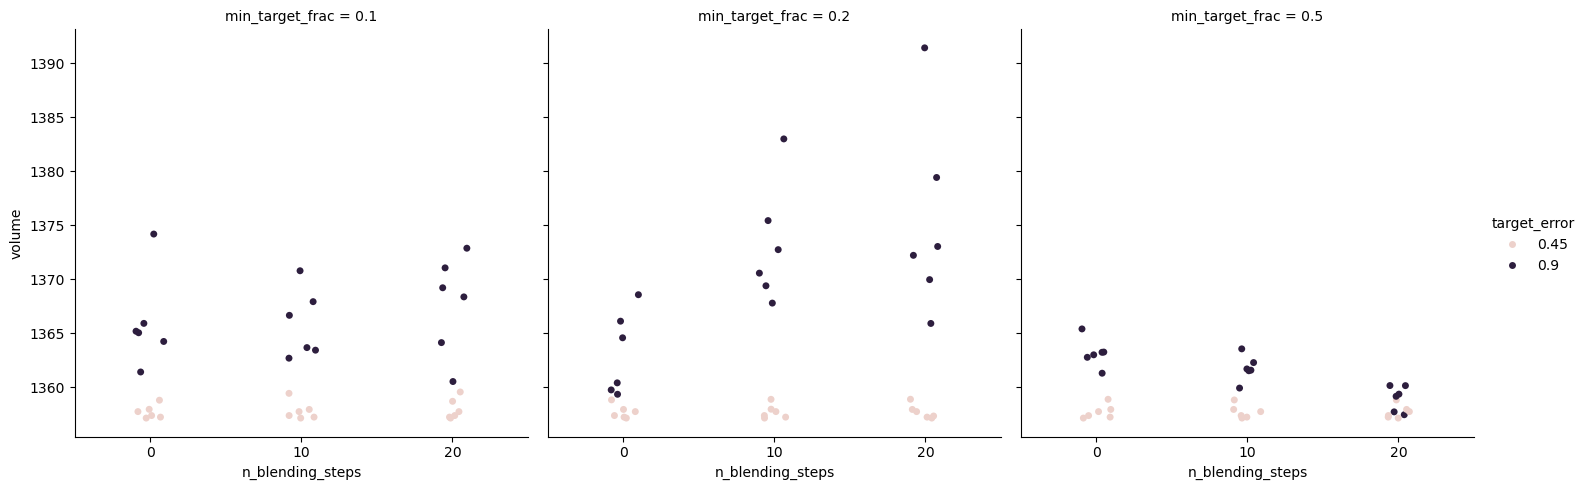

In [28]:
v_mean.head()
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            y='volume',
            data=v_mean.query('volume < 1e5'),
            sharey=True)
plt.show()

In [29]:
rho_mean = experimental.query('timestep > 1024').groupby(param_vars)['rho'].mean().reset_index()
rho_mean['rho_abs_pct_error'] = np.abs(rho_mean['rho'] - rho_ref) / rho_ref * 100

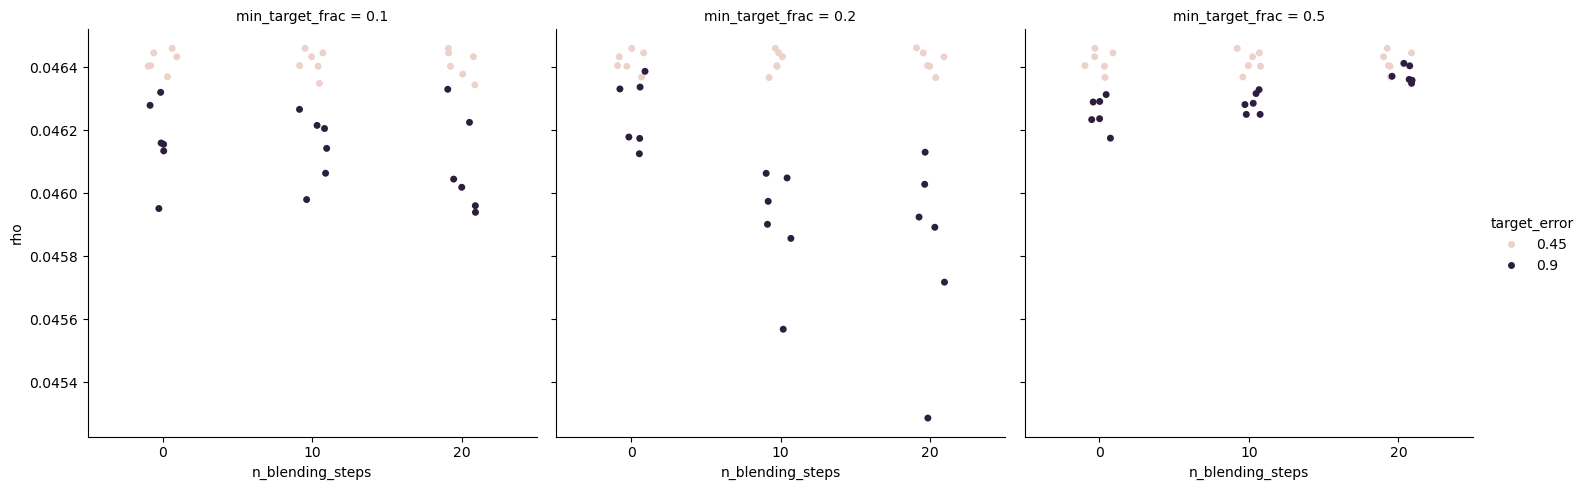

In [30]:
rho_mean.head()
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            y='rho',
            data=rho_mean,
            sharey=True)

                
plt.show()

In [31]:
sns.set_style('whitegrid')

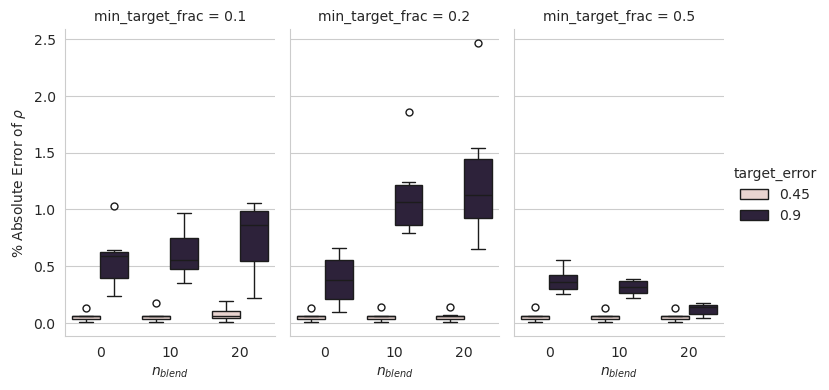

In [32]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            y='rho_abs_pct_error',
            data=rho_mean,
            sharey=True,
            height=4, 
            kind='box',
            aspect=2/(1 + np.sqrt(5))
            )

g.set_ylabels(r'% Absolute Error of $\rho$')
g.set_xlabels(r'$n_{blend}$')
                
plt.show()

In [33]:
rho_means = rho_mean.groupby(['n_blending_steps', 'min_target_frac', 'target_error'])['rho'].mean()
rho_means

n_blending_steps  min_target_frac  target_error
0                 0.1              0.45            0.046420
                                   0.90            0.046167
                  0.2              0.45            0.046420
                                   0.90            0.046256
                  0.5              0.45            0.046420
                                   0.90            0.046257
10                0.1              0.45            0.046416
                                   0.90            0.046146
                  0.2              0.45            0.046419
                                   0.90            0.045903
                  0.5              0.45            0.046420
                                   0.90            0.046286
20                0.1              0.45            0.046411
                                   0.90            0.046087
                  0.2              0.45            0.046420
                                   0.90            0

In [34]:
rho_ref = dft_only['rho'].mean()
rho_abs_err = (np.abs(rho_means - rho_ref) / rho_ref) * 100
rho_abs_err

n_blending_steps  min_target_frac  target_error
0                 0.1              0.45            0.025461
                                   0.90            0.569738
                  0.2              0.45            0.025753
                                   0.90            0.378558
                  0.5              0.45            0.026156
                                   0.90            0.376215
10                0.1              0.45            0.032935
                                   0.90            0.615427
                  0.2              0.45            0.026546
                                   0.90            1.139720
                  0.5              0.45            0.025642
                                   0.90            0.313868
20                0.1              0.45            0.044385
                                   0.90            0.742602
                  0.2              0.45            0.025764
                                   0.90            1

In [35]:
rho_abs_err = rho_abs_err.reset_index()

In [36]:
rho_abs_err

,n_blending_steps,min_target_frac,target_error,rho
0,0,0.1,0.45,0.025461
1,0,0.1,0.90,0.569738
2,0,0.2,0.45,0.025753
3,0,0.2,0.90,0.378558
4,0,0.5,0.45,0.026156
5,0,0.5,0.90,0.376215
6,10,0.1,0.45,0.032935
7,10,0.1,0.90,0.615427
8,10,0.2,0.45,0.026546
9,10,0.2,0.90,1.139720


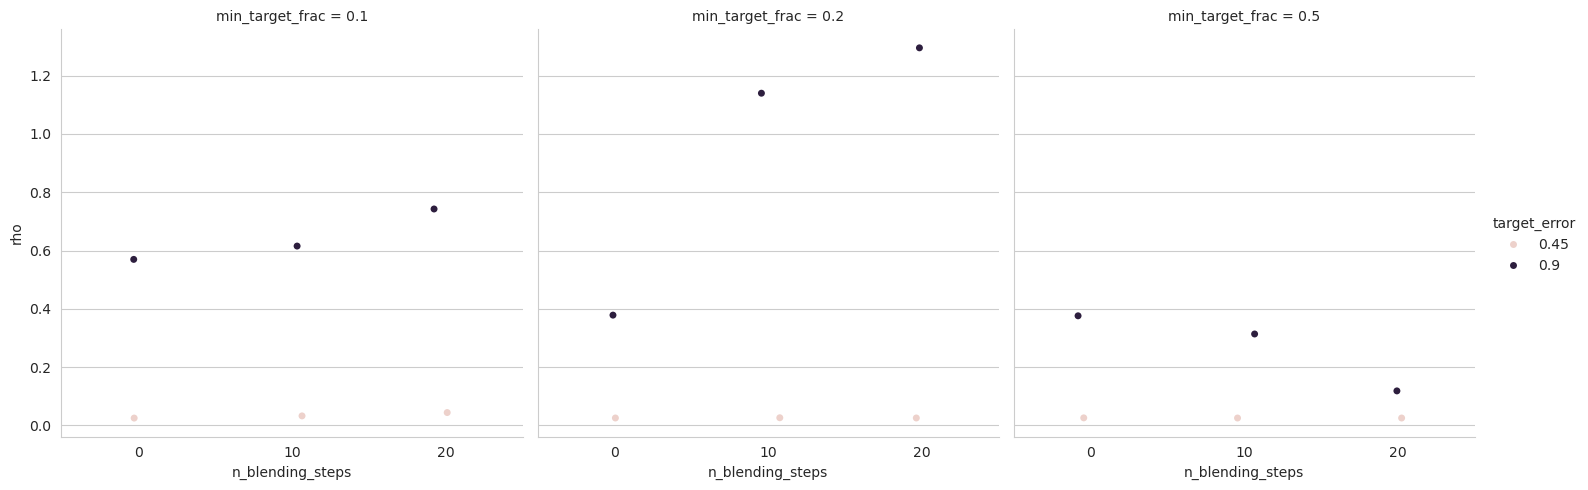

In [37]:
sns.catplot(data=rho_abs_err, 
            y='rho', 
            col='min_target_frac',
            x='n_blending_steps',
            hue='target_error'
           )
plt.show()

## Target fraction

Contextualizing the above results, the takeaways: 
* for 0.45 target error, we are accurate because we just use the DFT almost all of the time
* Same goes for the large min target frac + blending case

In [38]:
frac_target = []
for _hash, g  in experimental.groupby('hash'): 
    frac_target.append((_hash, g['target_invocations'].iloc[-1] / g['total_invocations'].iloc[-1]))
frac_target = pd.DataFrame.from_records(frac_target, columns=['hash', 'frac_target'])

In [39]:
frac_target = pd.merge(frac_target, params.query('min_target_frac < 1'), on='hash', how='left')

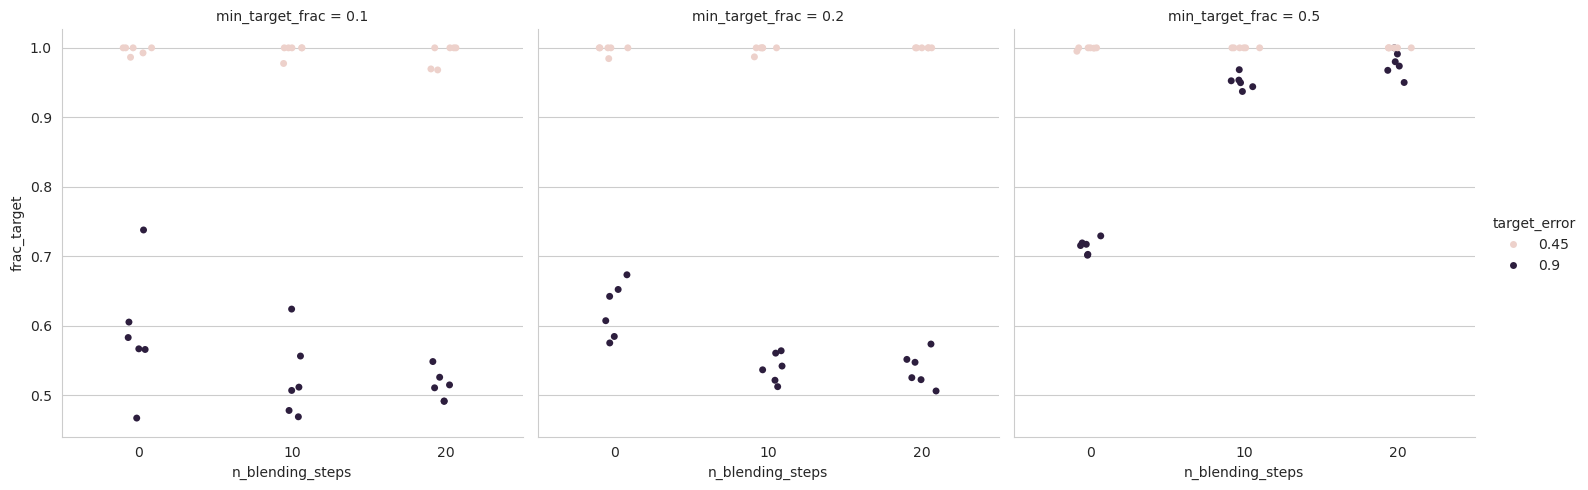

In [40]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            y='frac_target',
            data=frac_target,
            sharey=True,
            sharex=False)
plt.show()

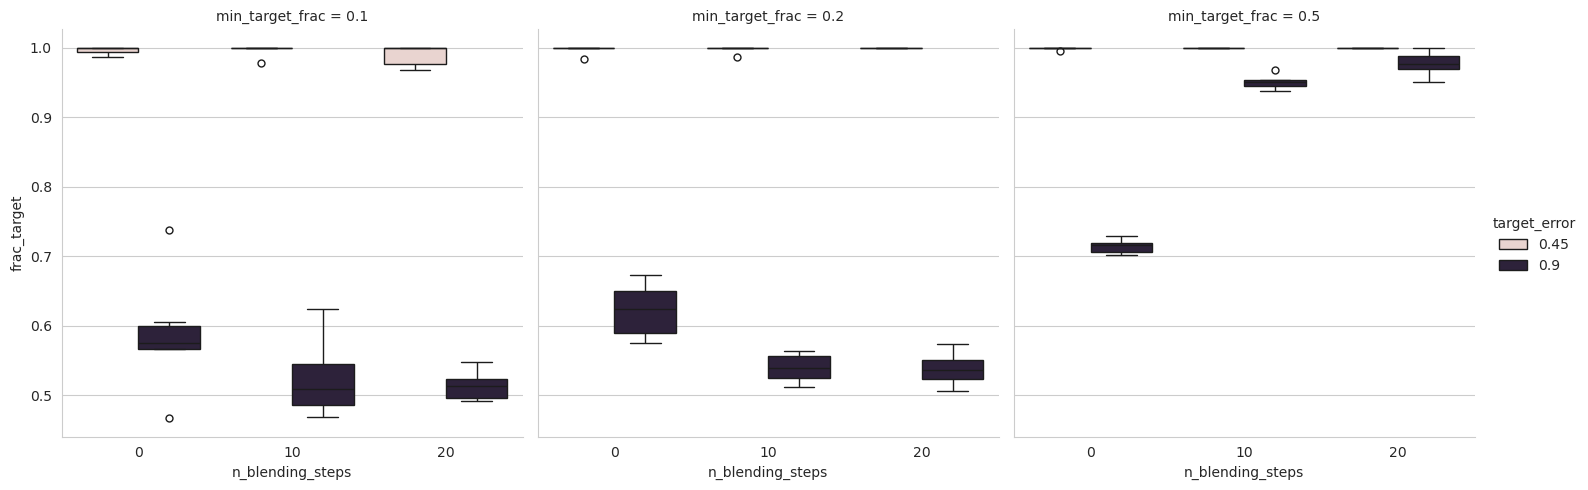

In [41]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            y='frac_target',
            data=frac_target,
            kind='box',
            sharey=True,
            sharex=False)
plt.show()

In [42]:
frac_target['pct_target'] = frac_target['frac_target'] * 100

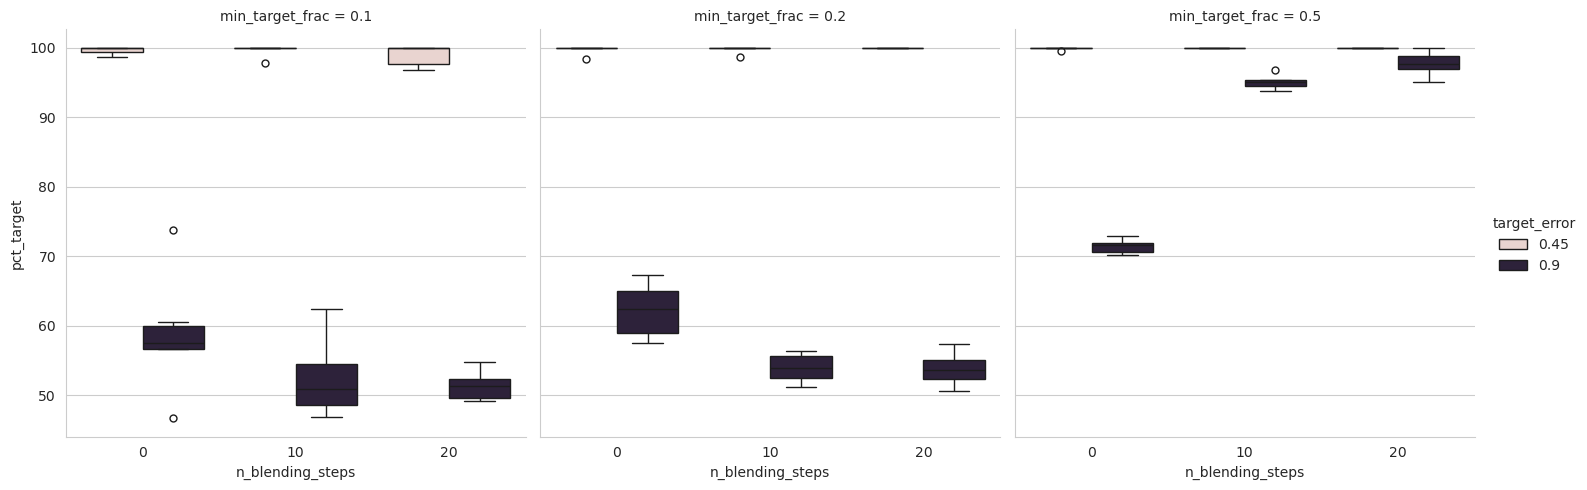

In [43]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            y='pct_target',
            data=frac_target,
            kind='box',
            sharey=True,
            sharex=False)
plt.show()

## Cost / accuracy plot

looking at frac_target and the other params

In [44]:
frac_target['metric'] = 'frac_target'
frac_target['value'] = frac_target['frac_target'].copy() * 100

rho_mean['metric'] = 'rho_mean'
rho_mean['value'] = rho_mean['rho_abs_pct_error'].copy()

In [45]:
cost_accuracy = pd.concat([rho_mean, frac_target]).reset_index()

In [46]:
g.set_ylabels?

Signature: g.set_ylabels(label=None, clear_inner=True, **kwargs)
Docstring: Label the y axis on the left column of the grid.
File:      ~/miniconda3/envs/cascade/lib/python3.11/site-packages/seaborn/axisgrid.py
Type:      method

In [47]:
g.axes[0]

array([<Axes: title={'center': 'min_target_frac = 0.1'}, xlabel='n_blending_steps', ylabel='pct_target'>,
       <Axes: title={'center': 'min_target_frac = 0.2'}, xlabel='n_blending_steps'>,
       <Axes: title={'center': 'min_target_frac = 0.5'}, xlabel='n_blending_steps'>],
      dtype=object)

In [48]:
#cost_accuracy.rename({'min_target_frac': 'min_target_freq'}

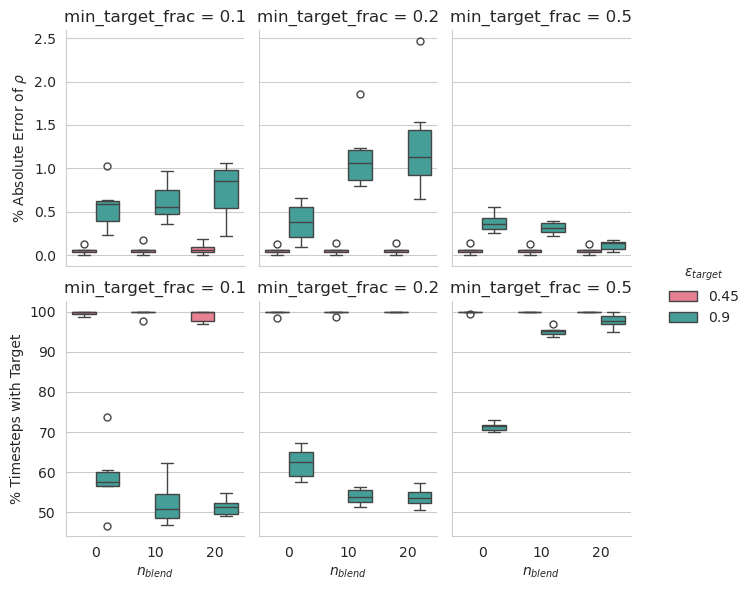

In [49]:
g = sns.catplot(x='n_blending_steps',
            col='min_target_frac', 
            hue='target_error',
            row='metric',
            y='value',
            data=cost_accuracy,
            sharey='row',
            height=3, 
            kind='box',
            aspect=2/(1 + np.sqrt(5)),
            palette=sns.color_palette("husl", 2)
            )



y_labels = [r'% Absolute Error of $\rho$', r'% Timesteps with Target']
for i, row in enumerate(g.axes):
    for j, ax in enumerate(row):
        if j == 0:
            ax.set_ylabel(y_labels[i])
        ax.set_title(ax.get_title().split(' | ')[-1])
g.set_xlabels(r'$n_{blend}$')
g.legend.set_title(r'$\epsilon_{target}$')
sns.move_legend(g, loc='center right', bbox_to_anchor=(1.1625,0.5))
plt.tight_layout()
plt.savefig('cost_accuracy_npt.png', bbox_inches='tight', dpi=600)
plt.show()